1. На основе учебного ноутбука проведите финальную подготовку данных. Измените количество сегментирующих классов с `16` на `7`:
  - 0_класс - FLOOR
  - 1_класс - CEILING
  - 2_класс - WALL
  - 3_класс - APERTURE, DOOR, WINDOW
  - 4_класс - COLUMN, RAILINGS, LADDER
  - 5_класс - INVENTORY
  - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Изучите внимательно особенности `U-net`, определите в чем принципиальное отличие  `U-net `  и   `simpleUnet` из учебного ноутбука.

3. Доработайте `simpleUnet` с учетом особенностей `U-net `. Обучите модель на 100 эпохах и визуализируйте результат.

**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

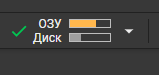

Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:10<00:00, 19.9MB/s]


### Предварительная подготовка данных


In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256             # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.26c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.27c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


## Решение

In [ ]:
# Ваше решение

## "На основе учебного ноутбука проведите финальную подготовку данных."

In [ ]:
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

In [ ]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [ ]:
# Формирование обучающей выборки

x_train = []

for img in train_images:
    x = image.img_to_array(img)
    x_train.append(x)

x_train = np.array(x_train)
print(x_train.shape)

(1900, 192, 256, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []

for img in val_images:
    x = image.img_to_array(img)
    x_val.append(x)

x_val = np.array(x_val)
print(x_val.shape)

(100, 192, 256, 3)


In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list
                 ):

    result = []


    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')


        for i, cl in enumerate(CLASS_LABELS):

            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list
                 ):

    result = []


    for y in image_list:

        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')


        for i, cl in enumerate(CLASS_LABELS):

            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)

In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


##"Измените количество сегментирующих классов с 16 на 7:
0_класс - FLOOR
1_класс - CEILING
2_класс - WALL
3_класс - APERTURE, DOOR, WINDOW
4_класс - COLUMN, RAILINGS, LADDER
5_класс - INVENTORY
6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE

In [ ]:
# Вычисление количества пикселов по всем классам в y_train

pix_count = np.zeros(NUM_CLASSES)
for i in range(NUM_CLASSES):
    pix_count[i] = (y_train == i).sum()

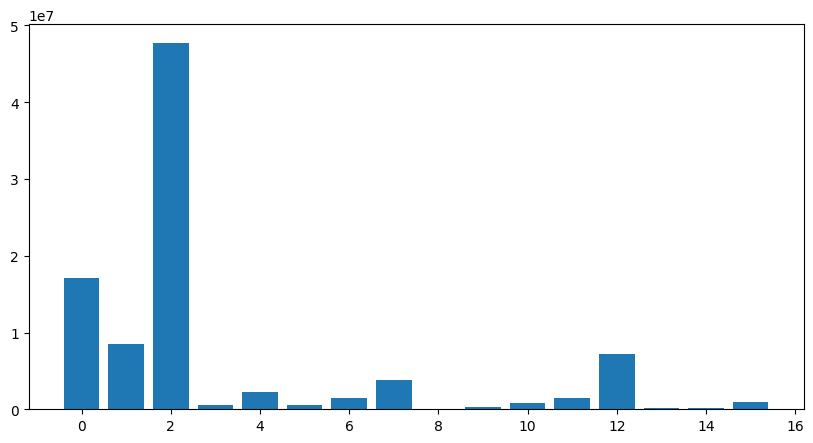

In [ ]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(NUM_CLASSES), pix_count)
plt.show()

In [ ]:
y_train7 = y_train.copy()
y_train7[(y_train7 > 4) & (y_train7 < 8)] = 3
y_train7[np.isin(y_train7, [4, 9, 12])] = 4
y_train7[y_train7 == 13] = 5
y_train7[(y_train7 > 7) & (y_train7 != 9) & (y_train7 != 12) & (y_train7 != 13) & (y_train7 < 17)] = 6


In [ ]:
y_val7 = y_val.copy()
y_val7[(y_val7 > 4) & (y_val7 < 8)] = 3
y_val7[np.isin(y_val7, [4, 9, 12])] = 4
y_val7[y_val7 == 13] = 5
y_val7[(y_val7 > 7) & (y_val7 != 9) & (y_val7 != 12) & (y_val7 != 13) & (y_val7 < 17)] = 6


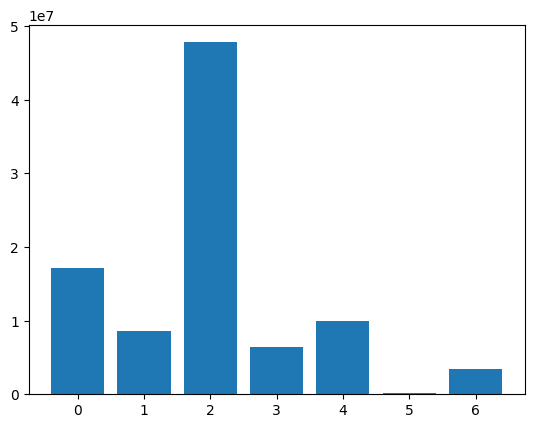

In [ ]:
classes, counts = np.unique(y_train7, return_counts=True)
plt.bar(classes, counts)
plt.show()

In [ ]:
counts

array([17153712,  8556970, 47767734,  6422346,  9897293,   146129,
        3444616])

In [ ]:
classes

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

## "Изучите внимательно особенности U-net, определите в чем принципиальное отличие U-net и simpleUnet из учебного ноутбука."

Принципиальным отличием архитектуры simpleUnet от архитектуры U-net является то, что в ней мы неиспользуем BathNormalization() и используем меньшее количество пробросов между кодером и декодером. Из-за чего данная архетиктура работает на много быстрее.

##"Доработайте simpleUnet с учетом особенностей U-net. Обучите модель на 100 эпохах и визуализируйте результат."

#### модель U-net из учебного ноутбука

In [ ]:
# модель U-net из учебного ноутбука
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

### Модель simpleUnet из учебного ноутбука

In [ ]:
# Модель simpleUnet из учебного ноутбука
def simple_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 32-нейронами
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D(4)(block_1_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D(4)(block_2_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза

    # UP 1
    x = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 64-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 32-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

### Доработанная модель simpleUnet с учетом особенностей U-net

In [ ]:
class_count = len(classes)

In [ ]:
def Dsimple_unet(class_count,
                input_shape
                ):

    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D(4)(block_1_out)

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D(4)(block_2_out)

    # UP 1
    x = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)


    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])


    return model

In [ ]:
model_Dsimple_unet = Dsimple_unet(class_count,
                                (IMG_WIDTH, IMG_HEIGHT, 3))

In [ ]:
history = model_Dsimple_unet.fit(x_train, y_train7,
                                epochs=100, batch_size=32,
                                validation_data=(x_val, y_val7))

Epoch 1/100
60/60 [==============================] - 35s 336ms/step - loss: 1.3156 - sparse_categorical_accuracy: 0.5172 - val_loss: 1.6042 - val_sparse_categorical_accuracy: 0.4594
Epoch 2/100
60/60 [==============================] - 17s 276ms/step - loss: 0.9602 - sparse_categorical_accuracy: 0.6510 - val_loss: 1.5533 - val_sparse_categorical_accuracy: 0.4011
Epoch 3/100
60/60 [==============================] - 17s 285ms/step - loss: 0.8709 - sparse_categorical_accuracy: 0.6868 - val_loss: 1.5247 - val_sparse_categorical_accuracy: 0.4152
Epoch 4/100
60/60 [==============================] - 18s 293ms/step - loss: 0.8279 - sparse_categorical_accuracy: 0.7026 - val_loss: 1.4548 - val_sparse_categorical_accuracy: 0.4552
Epoch 5/100
60/60 [==============================] - 17s 288ms/step - loss: 0.7916 - sparse_categorical_accuracy: 0.7135 - val_loss: 1.1562 - val_sparse_categorical_accuracy: 0.5782
Epoch 6/100
60/60 [==============================] - 17s 283ms/step - loss: 0.7665 - spars

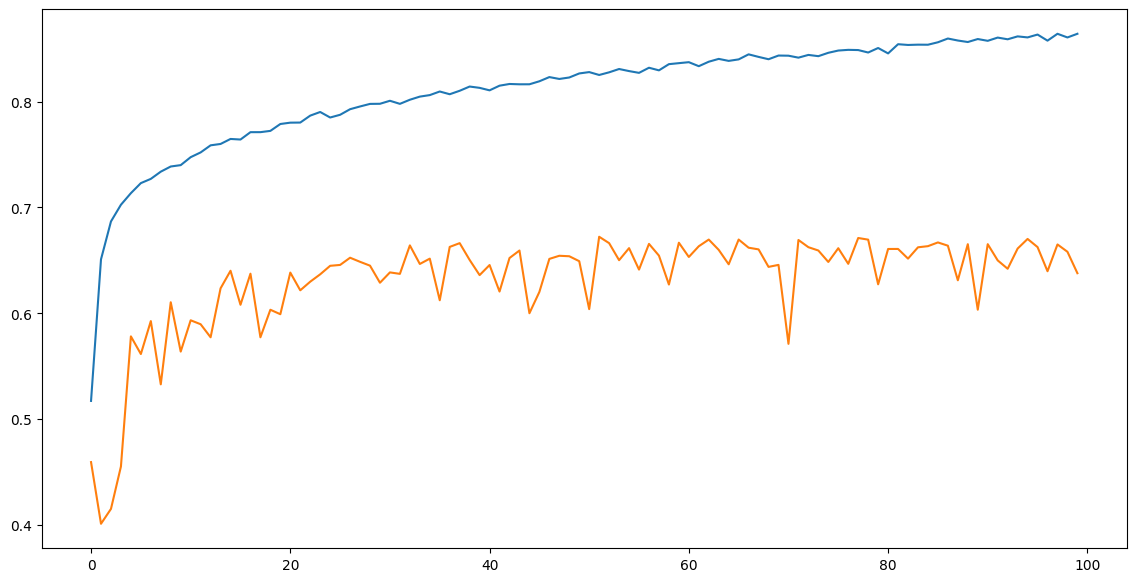

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,
                   count = 1
                   ):


    indexes = np.random.randint(0, len(x_val), count)


    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)


    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))


    for i in range(count):

        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')


        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')


        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

1/1 [==============================] - 1s 970ms/step


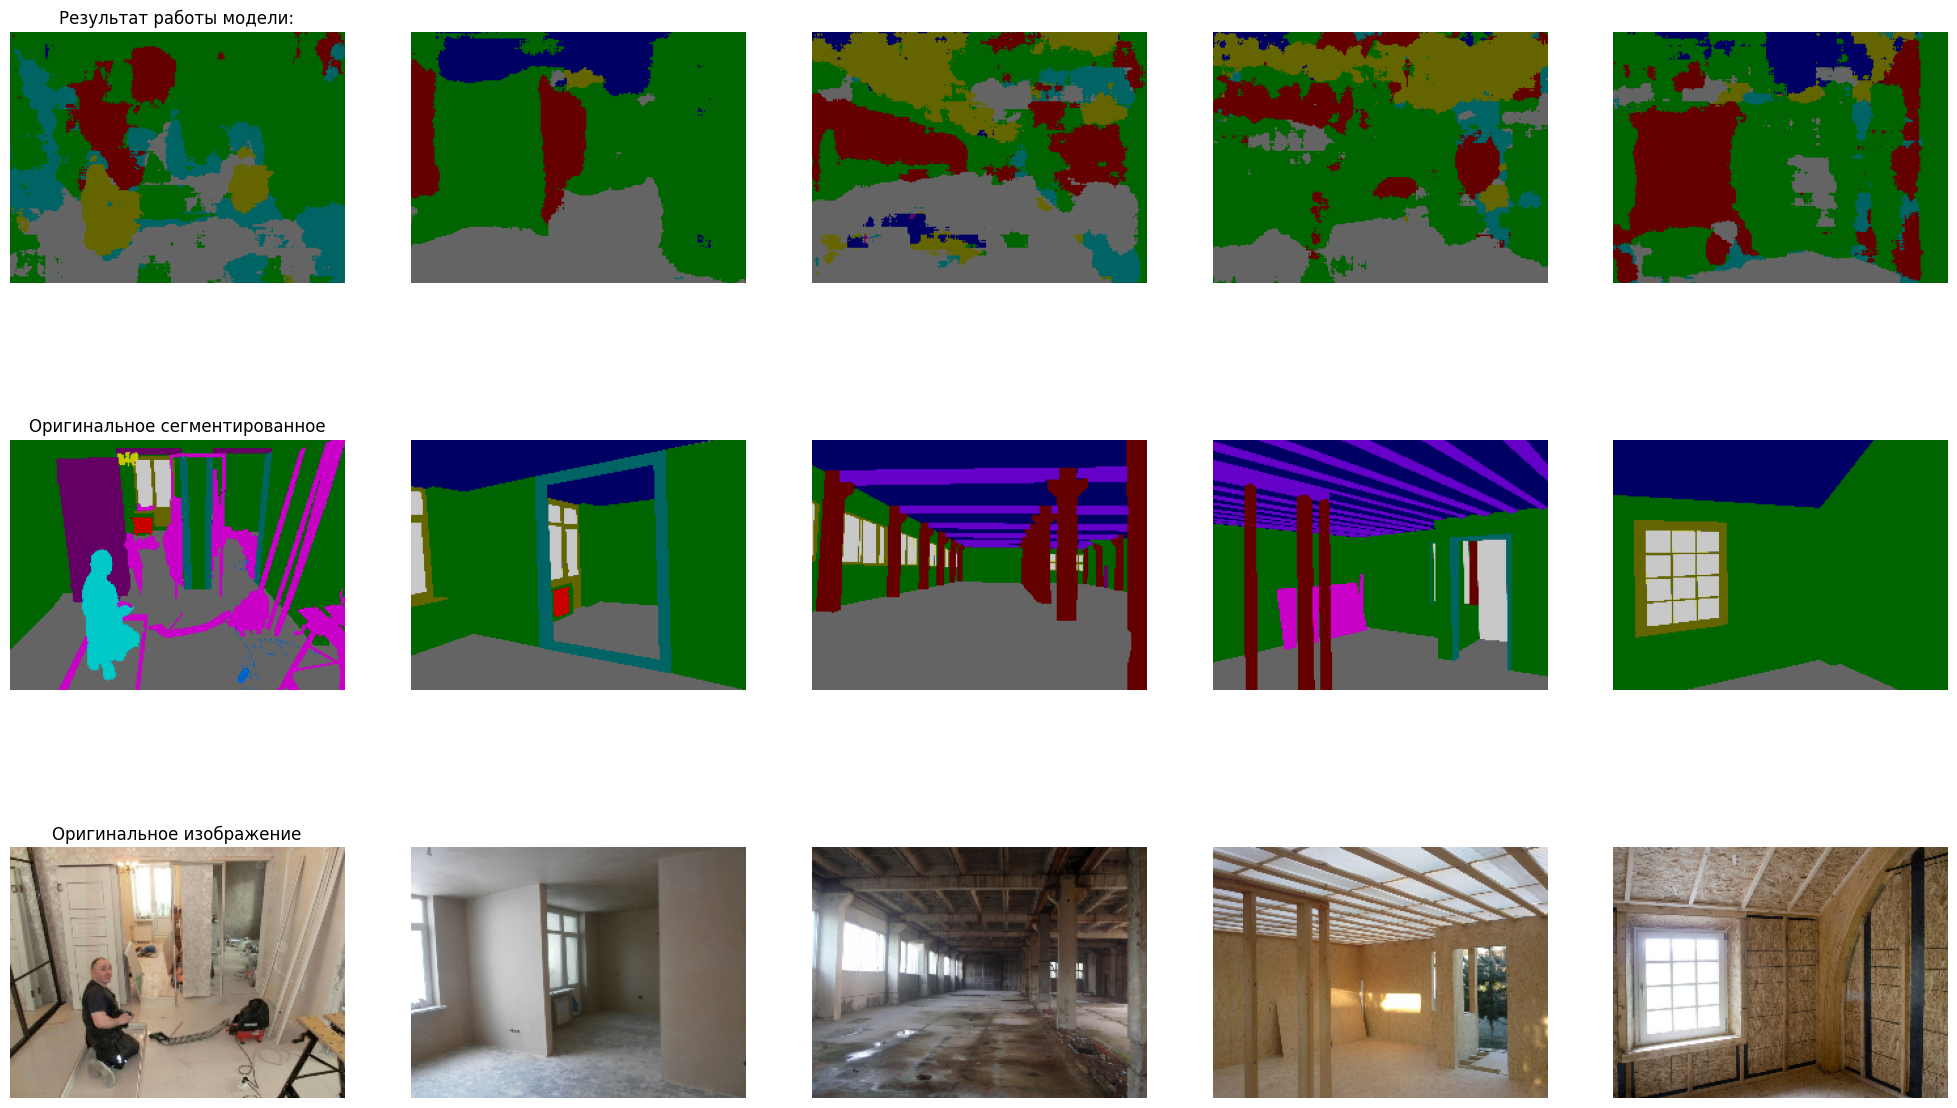

In [ ]:
process_images(model_Dsimple_unet, 5)